# Computer Vision, Dr. Aygul Zagidullina, Dr. Dimitris Mousadakos

# Transfer Learning Exercise

*  Tech companies and university labs have more computational resources than we do
*  Let them train their very complex models on millions of images, and then re-use their kernels for our own CNNs!

🎯 **<u>Goal:</u>**
* ☄️ Use a **Pretrained Neural Network** $ \Leftrightarrow $ **Transfer learning**

## Google Colab Setup

Repeat the same process from the last example to upload and open your notebook:

1. access your [Google Drive](https://drive.google.com/)
2. go into the Colab Notebooks folder
3. drag and drop this notebook into it
4. right-click the notebook file and select `Open with` $\rightarrow$ `Google Colaboratory`

Don't forget to enable GPU acceleration!

`Runtime` $\rightarrow$ `Change runtime type` $\rightarrow$ `Hardware accelerator` $\rightarrow$ `GPU`

When this is done, run the cells below and get to work!

## (1) What is a Pre-Trained Neural Network?

* Convolutions are mathematical operations designed to detect specific patterns in input images and use them to classify the images.
* One could imagine that these patterns are not 100% specific to one task but to the input images.

🚀 **Why not re-use these kernels - whose weights have already been optimized - somewhere else?**
- The expectation is that the trained kernels could also help us perform another classification task.
- We are trying to ***transfer*** the knowledge of a trained CNN to a new classification task.


💪 Transfer Learning has two main advantages:
- It takes less time to train a pre-trained model since we are not going to update all the weights but only some of them
- You benefit from state-of-the-art architectures that have been trained on complex images.

## (2) Introduction to  VGG16

📚 ***Reading Section, no code***






In this exercise, we will use the <a href="https://neurohive.io/en/popular-networks/vgg16/">**`VGG-16 Neural Network`**</a>.

> VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.

VGG16 is a well-known architecture that has been trained on the <a href="https://www.image-net.org/">**`ImageNet dataset`**</a> which is a very large database of images which belong to different categories.

👉 This architecture already learned which kernels are the best for extracting features from the images found in the `ImageNet dataset`.

👉 As we can see in the illustration, the VGG16 involves millions of parameters we don't want to retrain ourself.


<center><img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width=400></center>

❓ How does it work in practice ❓

* The first layers are not specialized for the particular task the VGG16 CNN was trained on
* Only the last dense layer is a "classification layers" that can be preceded with a couple of dense layers...  Therefore, we will:
    1. Load the existing VGG16 network
    2. Remove the last fully connected layers
    3. Replace them with some new fully-connected layers (whose weights are randomly set)
    4. Train these last layers on a specific classification task.

😃 Our role is to train only the last layers for our particular problem.

🤓 We will use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16">**`tensorflow.keras.applications.VGG16`**</a>

<hr>

## (3) Data loading & Preprocessing

We have two options to load the data into Google Colab.

### (Option 1) Loading the data directly

* You can first get the data onto google Colab thanks to:

`Files` $\rightarrow$ `Upload to session storage`,

* and then run

`!unzip flowers-dataset.zip`

*This is a very easy option to load the data into your working directory.*

### (Option 2) Adding the data to Google Drive

* You can first download the data from GitLab
* You have to add it to your Google Drive in a folder called `transfer_learning_data` (for instance)
* And run the following code in the notebook:

```python
from google.colab import drive
drive.mount('/content/drive/')
```

* The previous code will ask you to go to a given webpage where you can copy a temporary key
* Paste it in the cell that will appear in your Colab Notebook
* You can now load the data on your Google Colab Notebooks

```python
# Put Colab in the context of this exercise
import os

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/Colab Notebooks/transfer_learning_data')
```

### Option 1 or Option 2 ?

* Why choosing option 2 over the option 1?
    * ✅ The combo Colab + Drive can be interesting if you work within a project team, and need to update the data from time to time.
    * ✅ By doing this, you can share the same data folder with your teammates, and be sure that everyone has the same dataset at any time, even though someone changes it.
    * ❌ Google Colab has now access to your Google Folder..., which you may or may not be in favor of, depending on your sensibilities...

---

❓ **Question: Loading your dataset** ❓
    
Use one of the above methods to load our data

In [1]:
option_1 = True # Choose here

if option_1:
    !unzip flowers-dataset.zip -y
else:
    from google.colab import drive
    drive.mount('/content/drive/')

Archive:  flowers-dataset.zip
caution: filename not matched:  -y


In [2]:
!pwd

/Users/dmousadakos/Downloads/Computer_Vision


In [3]:
!ls

Exercises
Exercises.zip
cat-and-dog
cat-and-dog.zip
circles-and-triangles
circles-and-triangles.zip
data
flowers
flowers-dataset.zip
intro_to_image_processing_Colab_version.ipynb
intro_to_pytorch.ipynb
tf_computer_vision_Colab_version.ipynb
tf_intro_to_convolutions_Colab_version.ipynb
tf_transfer_learning_Colab_version.ipynb
torch_intro_to_convolutions_Colab_version.ipynb
torch_transfer_learning_Colab_version.ipynb


❓ **Question:Train/Val/Test split** ❓

Use the following method to create
`X_train, y_train, X_val, y_val, X_test, y_test, num_classes` depending on the `loading_method` you have used

In [4]:
import torch
from tqdm import tqdm
import numpy as np
import os
from PIL import Image

In [5]:
def load_flowers_data(loading_method):
    """
    Loads and preprocesses the flowers dataset for PyTorch.

    Args:
      loading_method (str): 'colab' or 'direct' to specify the data path.

    Returns:
      tuple: A tuple containing:
          - X_train (torch.Tensor): Training image data.
          - y_train (torch.Tensor): Training labels.
          - X_val (torch.Tensor): Validation image data.
          - y_val (torch.Tensor): Validation labels.
          - X_test (torch.Tensor): Test image data.
          - y_test (torch.Tensor): Test labels.
          - num_classes (int): The number of unique classes.
    """
    if loading_method == 'colab':
        data_path = '/content/drive/My Drive/transfer_learning_data/flowers'
    elif loading_method == 'direct':
        data_path = 'flowers/'
    
    classes = {'daisy': 0, 'dandelion': 1, 'rose': 2}
    imgs = []
    labels = []

    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg') > 0]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

    # Convert to NumPy arrays first
    X = np.array(imgs)
    y = np.array(labels)

    # Shuffle the data
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    # Split the data
    first_split = int(len(imgs) / 6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    # --- PyTorch specific changes ---
    
    # 1. Convert NumPy arrays to PyTorch Tensors
    #    - PyTorch models expect image data as float tensors.
    #    - Labels for classification are expected as long (integer) tensors.
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).long()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).long()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).long()
    
    # 2. Adjust image dimensions
    #    - PyTorch's convolutional layers expect input in the format (N, C, H, W):
    #      (Number of images, Channels, Height, Width)
    #    - The data is loaded as (N, H, W, C), so we need to permute the dimensions.
    X_train = X_train.permute(0, 3, 1, 2)
    X_val = X_val.permute(0, 3, 1, 2)
    X_test = X_test.permute(0, 3, 1, 2)

    num_classes = len(set(labels))

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [6]:
# CALL load_flowers_data WITH OUR PREFERRED METHOD HERE

X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_flowers_data('direct')


100%|███████████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 471.30it/s]


❓ **Question: Exploring the images** ❓

Check the images' shapes and plot a few of them.

In [7]:
print(X_train.shape, X_val.shape, X_test.shape)

torch.Size([571, 3, 256, 256]) torch.Size([179, 3, 256, 256]) torch.Size([149, 3, 256, 256])


In [8]:
y_train

tensor([1, 0, 2, 0, 2, 2, 0, 0, 2, 1, 0, 1, 1, 2, 2, 0, 1, 0, 1, 0, 0, 2, 0, 0,
        2, 1, 0, 1, 2, 2, 0, 1, 1, 0, 2, 1, 1, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 0,
        0, 0, 1, 2, 0, 0, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 1, 0, 0, 2, 1,
        0, 2, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 2, 0, 2, 0,
        2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 1, 2, 0, 2, 2, 0,
        2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2, 2,
        1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 2, 2, 1, 1, 0, 0, 2, 2, 2, 0, 0, 2, 2, 1,
        2, 2, 1, 2, 2, 2, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 2, 2, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 0, 0, 2, 0, 1, 1, 2, 1, 1, 0, 0, 0,
        2, 1, 2, 0, 1, 0, 0, 1, 2, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0,
        1, 2, 2, 2, 0, 0, 1, 2, 1, 1, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0,
        0, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 2, 0, 1, 2, 2, 1, 0, 1, 2, 1, 0, 0,
        0, 1, 1, 1, 1, 2, 0, 0, 0, 1, 2,

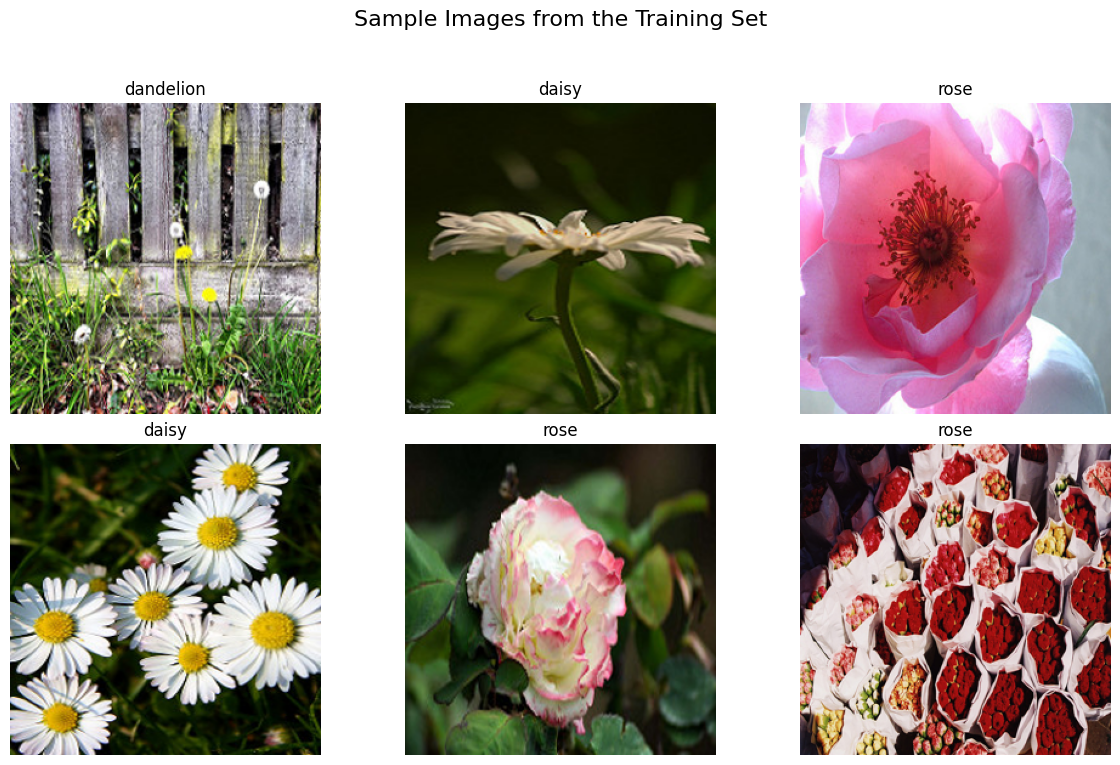

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --- You should have your function and data loaded above this line ---
# Example (assuming the function from the previous answer is defined):
# X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_flowers_data('direct')
# --------------------------------------------------------------------

# Create a mapping from class index back to class name for readable labels
class_names = {0: 'daisy', 1: 'dandelion', 2: 'rose'}

# Set up the figure for plotting
plt.figure(figsize=(12, 8))
plt.suptitle("Sample Images from the Training Set", fontsize=16)

# Loop to display the first 6 images
for i in range(6):
    # Create a subplot in a 2x3 grid
    plt.subplot(2, 3, i + 1)
    
    # Get the i-th image and label
    image_tensor = X_train[i]
    label_index = y_train[i].item() # .item() gets the scalar value from a tensor

    # --- Prepare the image for display ---
    # 1. Permute dimensions from (C, H, W) back to (H, W, C) for matplotlib
    image_for_plot = image_tensor.permute(1, 2, 0)
    
    # 2. Convert the tensor to a NumPy array and ensure it's an integer type
    image_for_plot = image_for_plot.numpy().astype(np.uint8)

    # Display the image
    plt.imshow(image_for_plot)
    
    # Set the title to the corresponding class name
    plt.title(class_names[label_index])
    
    # Hide the axes for a cleaner look
    plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## (4) A CNN architecture

First, let's build our own CNN.

❓ **Questions** ❓

1. <u>CNN Architecture and compiler:</u> Create a CNN with our own architecture and a function `load_own_model` that will be able to generate it. Some advice:
    - Incorporate the Rescaling Layer in our Sequential architecture
    - Add three Conv2D/MaxPooling2D combinations with an increasing number of channels and a decreasing size of kernels for example (be creative, that is not a rule of thumb, mastering CNN is an art)
    - Don't forget the Flatten layer and some hidden layers
    - Finish with the predictive layer
    - Compile our CNN model accordingly
  
  
2. <u>Training and comparison</u>:
    - Train our CNN
    - Compare its performance to a baseline accuracy

<details>
    <summary><i>Recommended architecture:</i></summary>

```python
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

model = Sequential()

# Notice this cool new layer that "pipe" your rescaling within the architecture
model.add(Rescaling(1./255, input_shape=(256,256,3)))

# Lets add 3 convolution layers, with relatively large kernel size as our pictures are quite big too
model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
model.add(layers.MaxPooling2D(3))

model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
model.add(layers.MaxPooling2D(3))

model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
model.add(layers.MaxPooling2D(3))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
```

        
</details>        

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm # For a nice progress bar
import copy # Needed for deepcopy in the EarlyStopper

# Define the CNN architecture as a Python class
class FlowerCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(FlowerCNN, self).__init__()
        
        # This sequential block handles the feature extraction (conv + pooling)
        self.features = nn.Sequential(
            # Layer 1: Conv2D(16, kernel_size=10) + ReLU + MaxPool2D(3)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            
            # Layer 2: Conv2D(32, kernel_size=8) + ReLU + MaxPool2D(3)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),

            # Layer 3: Conv2D(32, kernel_size=6) + ReLU + MaxPool2D(3)
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        
        # This sequential block handles the classification (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # The input features for the first Linear layer must be calculated.
            # After the conv layers, the tensor size is 32x6x6.
            nn.Linear(in_features=32 * 6 * 6, out_features=100),
            nn.ReLU(),
            # The output layer produces raw scores (logits) for each class.
            nn.Linear(in_features=100, out_features=num_classes)
        )

    # The forward pass defines how data flows through the layers
    def forward(self, x):
        # 1. Rescaling is done directly on the tensor (equivalent to Rescaling(1./255))
        x = x / 255.0
        
        # 2. Pass data through the feature extractor
        x = self.features(x)
        
        # 3. Pass data through the classifier to get the final scores
        logits = self.classifier(x)
        return logits

In [11]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        # Store the best model state in memory
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save the best model state using a deep copy
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"INFO: Early stopping triggered after {self.patience} epochs of no improvement.")
                self.early_stop = True

In [12]:
# Define the input size (batch_size, channels, height, width)
batch_size = 64
input_shape = (batch_size, 3, 256, 256)
# Instantiate the model
model = FlowerCNN()
summary(model, input_size=input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
FlowerCNN                                [64, 3]                   --
├─Sequential: 1-1                        [64, 32, 6, 6]            --
│    └─Conv2d: 2-1                       [64, 16, 247, 247]        4,816
│    └─ReLU: 2-2                         [64, 16, 247, 247]        --
│    └─MaxPool2d: 2-3                    [64, 16, 82, 82]          --
│    └─Conv2d: 2-4                       [64, 32, 75, 75]          32,800
│    └─ReLU: 2-5                         [64, 32, 75, 75]          --
│    └─MaxPool2d: 2-6                    [64, 32, 25, 25]          --
│    └─Conv2d: 2-7                       [64, 32, 20, 20]          36,896
│    └─ReLU: 2-8                         [64, 32, 20, 20]          --
│    └─MaxPool2d: 2-9                    [64, 32, 6, 6]            --
├─Sequential: 1-2                        [64, 3]                   --
│    └─Flatten: 2-10                     [64, 1152]                --
│   

In [13]:
# Select the device (GPU or CPU)
if torch.backends.mps.is_available():
    device = "mps"
    print(f"✅ Device set to Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = "cuda"
    print(f"✅ Device set to NVIDIA GPU (CUDA)")
else:
    device = "cpu"
    print(f"✅ Device set to CPU")

# ❗ THE FIX: Move the model's parameters to the selected device.
# This single line solves the entire error.
model.to(device)

print(f"Model has been successfully moved to the '{device}' device.")

✅ Device set to Apple Silicon GPU (MPS)
Model has been successfully moved to the 'mps' device.


In [14]:
# ==============================================================================
# STEP 2: PREPARE FOR TRAINING
# ==============================================================================

EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

# Instantiate your EarlyStopper
early_stopper = EarlyStopper(patience=5, min_delta=0)

In [15]:
# ==============================================================================
# STEP 3: RUN THE TRAINING LOOP
# ==============================================================================

print("🚀 Starting training...")
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]"):
        # Now, both `inputs` and `model` are on the same device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs) # This will now work without error
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # --- Validation Phase ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # --- Early Stopping Check ---
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break

# --- Restore Best Weights ---
print("Restoring best model weights...")
model.load_state_dict(early_stopper.best_model_state)

print("✅ Training finished.")

🚀 Starting training...


Epoch 1/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 1.0943 | Train Acc: 37.65% | Val Loss: 1.0996 | Val Acc: 36.87%


Epoch 2/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 1.0541 | Train Acc: 43.61% | Val Loss: 1.1798 | Val Acc: 26.26%


Epoch 3/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 0.9425 | Train Acc: 52.19% | Val Loss: 0.8599 | Val Acc: 56.42%


Epoch 4/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 0.8102 | Train Acc: 62.17% | Val Loss: 0.8545 | Val Acc: 54.19%


Epoch 5/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 0.8025 | Train Acc: 62.35% | Val Loss: 0.9395 | Val Acc: 51.40%


Epoch 6/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 0.7730 | Train Acc: 65.85% | Val Loss: 0.7726 | Val Acc: 64.80%


Epoch 7/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/100 | Train Loss: 0.7360 | Train Acc: 69.18% | Val Loss: 0.7549 | Val Acc: 62.57%


Epoch 8/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/100 | Train Loss: 0.7167 | Train Acc: 71.10% | Val Loss: 0.7540 | Val Acc: 65.92%


Epoch 9/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/100 | Train Loss: 0.6808 | Train Acc: 72.15% | Val Loss: 0.6864 | Val Acc: 68.72%


Epoch 10/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10/100 | Train Loss: 0.6566 | Train Acc: 72.50% | Val Loss: 0.7970 | Val Acc: 59.78%


Epoch 11/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11/100 | Train Loss: 0.6322 | Train Acc: 73.38% | Val Loss: 0.6828 | Val Acc: 69.83%


Epoch 12/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12/100 | Train Loss: 0.6265 | Train Acc: 75.48% | Val Loss: 0.6834 | Val Acc: 65.36%


Epoch 13/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13/100 | Train Loss: 0.6177 | Train Acc: 74.61% | Val Loss: 0.6429 | Val Acc: 71.51%


Epoch 14/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14/100 | Train Loss: 0.6188 | Train Acc: 73.38% | Val Loss: 0.6901 | Val Acc: 69.83%


Epoch 15/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15/100 | Train Loss: 0.6160 | Train Acc: 73.20% | Val Loss: 0.7146 | Val Acc: 67.60%


Epoch 16/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16/100 | Train Loss: 0.6053 | Train Acc: 74.96% | Val Loss: 0.6132 | Val Acc: 72.63%


Epoch 17/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17/100 | Train Loss: 0.5698 | Train Acc: 76.01% | Val Loss: 0.6141 | Val Acc: 74.30%


Epoch 18/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18/100 | Train Loss: 0.5560 | Train Acc: 77.23% | Val Loss: 0.6855 | Val Acc: 64.80%


Epoch 19/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19/100 | Train Loss: 0.5479 | Train Acc: 77.76% | Val Loss: 0.8142 | Val Acc: 60.89%


Epoch 20/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20/100 | Train Loss: 0.5613 | Train Acc: 76.36% | Val Loss: 0.6202 | Val Acc: 71.51%


Epoch 21/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 21/100 | Train Loss: 0.5094 | Train Acc: 78.63% | Val Loss: 0.6176 | Val Acc: 72.63%
INFO: Early stopping triggered after 5 epochs of no improvement.
Restoring best model weights...
✅ Training finished.


In [16]:
# Create a DataLoader for the preprocessed test set
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Set model to evaluation mode
model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

print("\n📊 Evaluating on the test set...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print("\n--- Final Test Results ---")
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


📊 Evaluating on the test set...


Testing:   0%|          | 0/10 [00:00<?, ?it/s]


--- Final Test Results ---
Average Test Loss: 0.6785
Test Accuracy: 69.80%


🥡 <b><u>Takeaways from building our own CNN</u></b>:
* On an "easy dataset" like the MNIST, it is now easy to reach a decent accuracy. But for a more complicated problem like classifying flowers, it already becomes more challenging. Let's take a few minutes to play with the following link before moving on to Transfer Learning
    * [PoloClub/CNN-Explainer](https://poloclub.github.io/cnn-explainer/)

## (5) Using a pre-trained CNN = Transfer learning

As it's said in the beginning, tech companies and university labs have more computational resources than we do.

🔥 The [**Visual Geometry Group**](https://www.robots.ox.ac.uk/~vgg/data/) *(Oxford University, Department of Science and Engineering)* became famous for some of their **Very Deep Convolutional Neural Networks**: the [**VGG16**](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

Take 7 minutes of your time to watch this incredible video of Convolutional Layers created by Dimitri Dmitriev.

* 📺 **[VGG16 Neural Network Visualization](https://www.youtube.com/watch?v=RNnKtNrsrmg)**


### (5.1) Load VGG16 model

❓ **Question: loading the VGG16** ❓

* Write a first function `load_model()` that loads the pretrained VGG-16 model from `torchvision.models`. Have a look at the documentation 📚  [tf/keras/applications/VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)📚

* We will **load the VGG16 model** the following way:
    - Let's use the **weights** learned on the [**imagenet dataset**](https://www.image-net.org/download.php) (14M pictures with 20k labels)
          
PyTorch models like VGG16 are typically built using `nn.Sequential` blocks for different parts of the network. For VGG16, the model is split into two main attributes:

* **`.features`**: This contains all the convolutional and pooling layers, responsible for extracting features from the image. This is the direct equivalent of the Keras model with `include_top=False`.
* **`.classifier`**: This contains the final fully connected (dense) layers that perform the classification based on the extracted features.

By loading the full model and then selecting `vgg_full_model.features`, you get exactly what you need for transfer learning.

<i><u>Remark:</u></i> Do not change the default value of the other arguments

In PyTorch's `torchvision` library, we achieve this by loading the complete model and then selecting its feature extraction part, which is conveniently separated.

In [17]:
import torchvision.models as models

# 1. Specify the pre-trained weights you want to use
#    VGG16_Weights.IMAGENET1K_V1 is the modern, recommended way.
weights = models.VGG16_Weights.IMAGENET1K_V1

# 2. Load the full pre-trained VGG16 model
vgg_full_model = models.vgg16(weights=weights)

# 3. To replicate `include_top=False`, you select the .features part of the model
vgg_features = vgg_full_model.features

# The `vgg_features` object is now your pre-trained convolutional base
print(vgg_features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Freezing the Pre-trained Layers

A crucial next step in transfer learning is to "freeze" the weights of the convolutional base so they don't get updated during the initial training of your new classifier. This prevents the valuable pre-trained knowledge from being destroyed.

You can do this by setting the `requires_grad` attribute of each parameter to `False`.

In [19]:
# --- Freeze the Layers ---
for param in vgg_features.parameters():
    param.requires_grad = False


❓ **Question: number of parameters in the VGG16** ❓

Let's look at the architecture of the model using ***summary()***

In [20]:
# Define the input size for the summary (batch_size, channels, height, width)
# VGG16 typically uses 224x224 images.
input_size = (1, 3, 224, 224)

print("\n\n--- MODEL SUMMARY (After Freezing) ---")
summary(vgg_features, input_size=input_size)



--- MODEL SUMMARY (After Freezing) ---


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 7, 7]            --
├─Conv2d: 1-1                            [1, 64, 224, 224]         (1,792)
├─ReLU: 1-2                              [1, 64, 224, 224]         --
├─Conv2d: 1-3                            [1, 64, 224, 224]         (36,928)
├─ReLU: 1-4                              [1, 64, 224, 224]         --
├─MaxPool2d: 1-5                         [1, 64, 112, 112]         --
├─Conv2d: 1-6                            [1, 128, 112, 112]        (73,856)
├─ReLU: 1-7                              [1, 128, 112, 112]        --
├─Conv2d: 1-8                            [1, 128, 112, 112]        (147,584)
├─ReLU: 1-9                              [1, 128, 112, 112]        --
├─MaxPool2d: 1-10                        [1, 128, 56, 56]          --
├─Conv2d: 1-11                           [1, 256, 56, 56]          (295,168)
├─ReLU: 1-12                             [1, 256, 56, 

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png">

Impressive, right? Two things to notice:
- It ends with a combo Conv2D/MaxPooling2D
- The `layers.Flatten` and the `layers.Dense` are not there yet, we need to add them.
- There are more than 14,000,000 parameters, which is a lot...
    - We could fine-tune them, i.e. update them as we will update the weights of the dense layers, but it will take a lot of time....
    - For this reason, we will inform the model that the layers before the flattening will be set non-trainable.

---

## Define a New Custom Classifier

The output of the VGG16 base isn't a final prediction; it's a large set of features. You need to create a small neural network (a "head") that takes these features and maps them to the number of classes in your dataset (daisy, dandelion, rose).

First, we must calculate the input size for our new classifier. From the model summary, we know the output of the VGG base is a tensor of shape `(batch_size, 512, 7, 7)`. When flattened, this becomes a vector of size **`512 * 7 * 7 = 25,088`**.

In [21]:
# The number of output features from the VGG base
input_features = 512 * 7 * 7 
# The number of classes in your dataset
num_classes = 3

# Define your new classifier
custom_classifier = nn.Sequential(
    # The Flatten layer is crucial to convert the 3D feature map to a 1D vector
    nn.Flatten(),
    
    # First fully connected layer
    nn.Linear(in_features=input_features, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.5), # Dropout helps prevent overfitting
    
    # Output layer with raw scores (logits) for each class
    nn.Linear(in_features=512, out_features=num_classes)
)

## Combine the Base and Classifier into a Final Model

Now, simply attach your new classifier to the frozen VGG base to create your complete transfer learning model.

In [22]:
# Create the final model by combining the frozen base and the new classifier
model = nn.Sequential(
    vgg_features,
    custom_classifier
)

# Move the final model to the correct device
model.to(device)

print("✅ Final transfer learning model created.")

✅ Final transfer learning model created.


## Prepare the Data and Optimizer

Pre-trained models like VGG16 expect input images to be preprocessed in a specific way (resized to 224x224 and normalized with certain values). We must apply these same transformations to our data.

Additionally, the optimizer should only be configured to update the weights of the **new classifier**, not the frozen base.

❓ **Question: chaining the pretrained convolutional layers of VGG16 with our own dense layers** ❓

We will write a function that adds flattening and dense layers after the convolutional layers. 

* The first line loads a group of layers which is the previous VGG-16 model.
* Then, we set these layers to be non-trainable.
* Eventually, we can instantiate as many layers as we want.
* Finally, we use the `Sequential` with the sequence of layers that will correspond to our overall neural network.

Replicate the following steps by adding:
* a flattening layer
* two dense layers (the first with 500 neurons) to the previous VGG-16 model.

In [23]:
from torchvision import transforms

# 1. Get the official VGG16 transforms
weights = models.VGG16_Weights.IMAGENET1K_V1
vgg_transforms = weights.transforms()

print("VGG16 Preprocessing Transforms:\n", vgg_transforms)

# You will need to apply these transforms to your X_train, X_val, and X_test tensors
# before creating the DataLoaders. For example:
# X_train_transformed = vgg_transforms(X_train)


# 2. Configure the optimizer to train ONLY the new classifier's parameters
# Note: We pass model[1].parameters() which refers to the custom_classifier
optimizer = optim.Adam(model[1].parameters(), lr=LEARNING_RATE)

# The loss function remains the same
loss_fn = nn.CrossEntropyLoss()

VGG16 Preprocessing Transforms:
 ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


❓ **Question: inspect the parameters of a customized VGG16** ❓

* Now look at the layers and the parameters of our model.
* Note that there is a distinction, at the end, between the **trainable** and **non-trainable parameters**

In [24]:
# Define a sample input size (batch_size, channels, height, width)
input_size = (16, 3, 224, 224)
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 3]                   --
├─Sequential: 1-1                        [16, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        (1,792)
│    └─ReLU: 2-2                         [16, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [16, 64, 224, 224]        (36,928)
│    └─ReLU: 2-4                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [16, 128, 112, 112]       (73,856)
│    └─ReLU: 2-7                         [16, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       (147,584)
│    └─ReLU: 2-9                         [16, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [16, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [16, 256, 56, 56]   

## Train the model

In [25]:
# Select the device (GPU or CPU)
if torch.backends.mps.is_available():
    device = "mps"
    print(f"✅ Device set to Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = "cuda"
    print(f"✅ Device set to NVIDIA GPU (CUDA)")
else:
    device = "cpu"
    print(f"✅ Device set to CPU")

# ❗ THE FIX: Move the model's parameters to the selected device.
# This single line solves the entire error.
model.to(device)

print(f"Model has been successfully moved to the '{device}' device.")

✅ Device set to Apple Silicon GPU (MPS)
Model has been successfully moved to the 'mps' device.


In [26]:
# ==============================================================================
# STEP 2: PREPARE FOR TRAINING
# ==============================================================================

EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

# 1. Get the official VGG16 transforms, which include resizing to 224x224 and normalization
weights = models.VGG16_Weights.IMAGENET1K_V1
vgg_transforms = weights.transforms()

print("Applying VGG16 preprocessing transforms to the data...")
# Apply the transforms to your existing data tensors
# Note: The data must be in (N, C, H, W) format and uint8 for the transforms to work correctly.
# The original loading code provides this.
X_train_transformed = vgg_transforms(X_train)
X_val_transformed = vgg_transforms(X_val)
X_test_transformed = vgg_transforms(X_test) # Also transform the test set for later

# 2. Create DataLoaders with the CORRECTLY SIZED data
train_dataset = TensorDataset(X_train_transformed, y_train)
val_dataset = TensorDataset(X_val_transformed, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Define optimizer to train ONLY the new classifier's parameters
# model[0] is the frozen VGG base. model[1] is our new custom_classifier.
optimizer = optim.Adam(model[1].parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

# 4. Instantiate your EarlyStopper
early_stopper = EarlyStopper(patience=5, min_delta=0)

print("✅ Data and optimizer are correctly configured for transfer learning.")

Applying VGG16 preprocessing transforms to the data...
✅ Data and optimizer are correctly configured for transfer learning.


In [27]:
# ==============================================================================
# STEP 3: RUN THE TRAINING LOOP
# ==============================================================================

print("🚀 Starting training...")
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]"):
        # Now, both `inputs` and `model` are on the same device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs) # This will now work without error
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # --- Validation Phase ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # --- Early Stopping Check ---
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break

# --- Restore Best Weights ---
print("Restoring best model weights...")
model.load_state_dict(early_stopper.best_model_state)

print("✅ Training finished.")

🚀 Starting training...


Epoch 1/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 17.5736 | Train Acc: 57.79% | Val Loss: 4.8049 | Val Acc: 74.30%


Epoch 2/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 5.1528 | Train Acc: 80.39% | Val Loss: 4.1736 | Val Acc: 75.98%


Epoch 3/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 2.1414 | Train Acc: 88.09% | Val Loss: 2.5940 | Val Acc: 79.89%


Epoch 4/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 1.3914 | Train Acc: 90.19% | Val Loss: 2.5533 | Val Acc: 77.09%


Epoch 5/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 0.7685 | Train Acc: 92.82% | Val Loss: 2.3289 | Val Acc: 77.09%


Epoch 6/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 0.5169 | Train Acc: 94.57% | Val Loss: 1.7560 | Val Acc: 80.45%


Epoch 7/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/100 | Train Loss: 0.5876 | Train Acc: 93.70% | Val Loss: 2.0825 | Val Acc: 82.68%


Epoch 8/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/100 | Train Loss: 0.3861 | Train Acc: 95.80% | Val Loss: 3.0795 | Val Acc: 72.63%


Epoch 9/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/100 | Train Loss: 0.3459 | Train Acc: 95.97% | Val Loss: 1.7031 | Val Acc: 79.89%


Epoch 10/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10/100 | Train Loss: 0.1349 | Train Acc: 98.25% | Val Loss: 1.7569 | Val Acc: 82.12%


Epoch 11/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11/100 | Train Loss: 0.0953 | Train Acc: 98.60% | Val Loss: 1.9957 | Val Acc: 79.33%


Epoch 12/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12/100 | Train Loss: 0.1168 | Train Acc: 98.07% | Val Loss: 1.8064 | Val Acc: 78.77%


Epoch 13/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13/100 | Train Loss: 0.0723 | Train Acc: 98.77% | Val Loss: 1.6881 | Val Acc: 81.56%


Epoch 14/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14/100 | Train Loss: 0.0056 | Train Acc: 99.65% | Val Loss: 1.6902 | Val Acc: 79.33%


Epoch 15/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15/100 | Train Loss: 0.1098 | Train Acc: 98.07% | Val Loss: 2.0093 | Val Acc: 79.33%


Epoch 16/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16/100 | Train Loss: 0.1505 | Train Acc: 98.25% | Val Loss: 1.5746 | Val Acc: 79.89%


Epoch 17/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17/100 | Train Loss: 0.1600 | Train Acc: 98.60% | Val Loss: 2.0136 | Val Acc: 82.12%


Epoch 18/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18/100 | Train Loss: 0.0990 | Train Acc: 98.42% | Val Loss: 1.7017 | Val Acc: 82.68%


Epoch 19/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19/100 | Train Loss: 0.1141 | Train Acc: 98.95% | Val Loss: 2.1976 | Val Acc: 77.65%


Epoch 20/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20/100 | Train Loss: 0.2768 | Train Acc: 97.02% | Val Loss: 3.6898 | Val Acc: 73.18%


Epoch 21/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 21/100 | Train Loss: 0.2506 | Train Acc: 97.90% | Val Loss: 2.1819 | Val Acc: 79.89%
INFO: Early stopping triggered after 5 epochs of no improvement.
Restoring best model weights...
✅ Training finished.


In [30]:
test_dataset = TensorDataset(X_test_transformed, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Set model to evaluation mode
model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

print("\n📊 Evaluating on the test set...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # This will now work correctly
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print("\n--- Final Test Results ---")
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


📊 Evaluating on the test set...


Testing:   0%|          | 0/10 [00:00<?, ?it/s]


--- Final Test Results ---
Average Test Loss: 4.2336
Test Accuracy: 74.50%


In [31]:
def plot_history(history, title='', axs=None, exp_name=""):
    """
    Plots the training and validation loss and accuracy from a PyTorch history dictionary.
    """
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
        
    # --- Plot Loss ---
    # CHANGED: Use the correct keys for PyTorch history
    ax1.plot(history['train_loss'], label='train' + exp_name)
    ax1.plot(history['val_loss'], label='val' + exp_name)
    ax1.set_title('Loss')
    ax1.legend()

    # --- Plot Accuracy ---
    # CHANGED: Use the correct keys for PyTorch history
    ax2.plot(history['train_acc'], label='train accuracy' + exp_name)
    ax2.plot(history['val_acc'], label='val accuracy' + exp_name)
    ax2.set_title('Accuracy')
    ax2.legend()
    
    # Add a main title for the whole plot
    if title:
        f.suptitle(title)
        
    return (ax1, ax2)

(<Axes: title={'center': 'Loss'}>, <Axes: title={'center': 'Accuracy'}>)

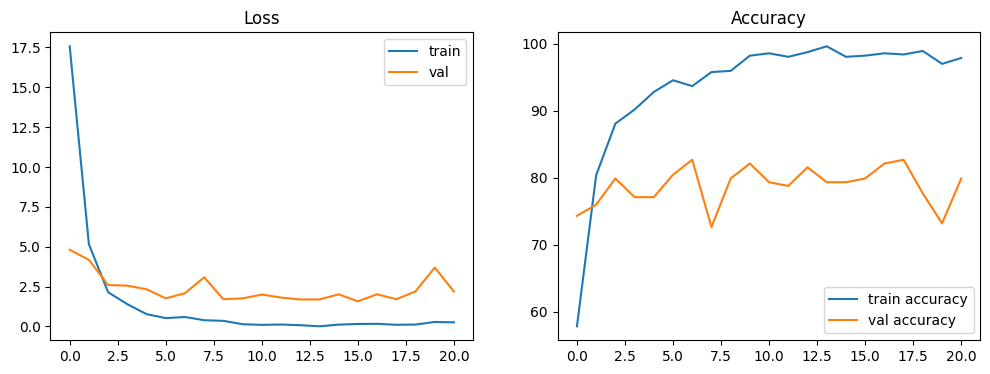

In [32]:
plot_history(history)

# Data preprocessing

### (5.2) Back to the data

🚨 The VGG16 model was trained on images which were preprocessed in a specific way. This is the reason why we did _NOT_ normalize them earlier.

❓ **Question: preprocessing the dataset** ❓

Apply the specific processing to the original (non-normalized) images here using the method **`preprocess`** from the pretrained model


In [33]:
# 1. Get the specific weights and their corresponding preprocessing transforms
weights = models.VGG16_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

# Let's inspect the preprocessing steps
print("--- VGG16 Preprocessing Steps ---")
print(preprocess)
print("-" * 33)


--- VGG16 Preprocessing Steps ---
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
---------------------------------


In [34]:
# 2. Apply the preprocessing to your data sets
# The input tensors (e.g., X_train) should be in (N, C, H, W) format with a uint8 dtype.
print("Applying preprocessing to the data...")

X_train_preprocessed = preprocess(X_train)
X_val_preprocessed = preprocess(X_val)

print("✅ Preprocessing complete.")


Applying preprocessing to the data...
✅ Preprocessing complete.


In [35]:

# 3. Verify the output shape and data type of the preprocessed data
print(f"\nOriginal shape: {X_train.shape}")
print(f"Shape after preprocessing: {X_train_preprocessed.shape}")
print(f"Data type after preprocessing: {X_train_preprocessed.dtype}")


Original shape: torch.Size([571, 3, 256, 256])
Shape after preprocessing: torch.Size([571, 3, 224, 224])
Data type after preprocessing: torch.float32


In [36]:
model.to(device)

EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

# Create DataLoaders using the preprocessed data
train_dataset = TensorDataset(X_train_preprocessed, y_train)
val_dataset = TensorDataset(X_val_preprocessed, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer to train ONLY the new classifier (model[1])
optimizer = optim.Adam(model[1].parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=5, min_delta=0)
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break

Epoch 1/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 0.5719 | Train Acc: 96.85% | Val Loss: 4.2025 | Val Acc: 75.42%


Epoch 2/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 1.3156 | Train Acc: 92.82% | Val Loss: 4.9544 | Val Acc: 75.98%


Epoch 3/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 1.3306 | Train Acc: 92.64% | Val Loss: 5.2127 | Val Acc: 76.54%


Epoch 4/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 0.8693 | Train Acc: 94.40% | Val Loss: 5.8350 | Val Acc: 74.86%


Epoch 5/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 0.9240 | Train Acc: 95.27% | Val Loss: 5.2267 | Val Acc: 77.65%


Epoch 6/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 0.9262 | Train Acc: 94.92% | Val Loss: 5.0086 | Val Acc: 79.33%
INFO: Early stopping triggered after 5 epochs of no improvement.


❓ **Question: Looking at the accuracy** ❓

Plot the accuracy for both the train set and and the validation set using the **plot_history** function below

In [40]:
test_dataset = TensorDataset(X_test_transformed, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Set model to evaluation mode
model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

print("\n📊 Evaluating on the test set...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # This will now work correctly
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print("\n--- Final Test Results ---")
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


📊 Evaluating on the test set...


Testing:   0%|          | 0/10 [00:00<?, ?it/s]


--- Final Test Results ---
Average Test Loss: 11.5309
Test Accuracy: 75.17%


❓ **Question: Looking at the accuracy** ❓

Plot the accuracy for both the train set and and the validation set using the **plot_history** function below

(<Axes: title={'center': 'Loss'}>, <Axes: title={'center': 'Accuracy'}>)

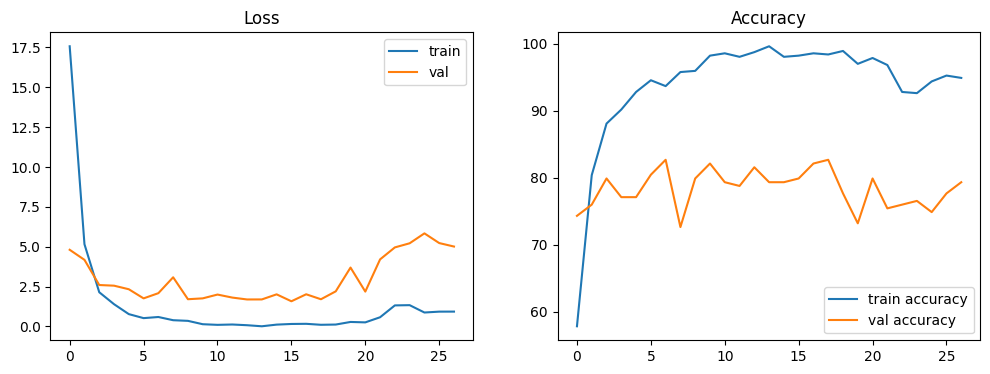

In [41]:
plot_history(history)

## (6) (Optional) Improve the model

Now, we can try to improve the model's test accuracy. To do that, here are some options we can consider

1. **Unfreeze and finetune**: Source: [Google tutorial](https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning)
>_Once your model has converged on the new data, you can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate. This is an optional last step that can potentially give you incremental improvements. It could also potentially lead to quick overfitting -- keep that in mind. It is critical to only do this step after the model with frozen layers has been trained to convergence. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features. It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates. Here, you only want to readapt the pretrained weights in an incremental way._


1. Add **Data Augmentation** if the model is overfitting.

2. If our model is not overfitting, try a more complex model.

3. Perform a precise **Grid Search** on all the hyper-parameters: learning_rate, batch_size, data augmentation etc...

4. **Change the base model** to more modern CNN (ResNet, EfficientNet1,... available in the keras library)

5. Curate the data: maintaining a sane data set is one of the keys to success.

6. Collect more data

## (6.1) Data augmentation


In [42]:
# ==============================================================================
# STEP 1: DEFINE THE AUGMENTATION PIPELINE (WITHOUT NORMALIZATION)
# ==============================================================================

# These transforms will be applied to create the new images.
# Note: ToTensor and Normalize are excluded because they will be applied later.
augmentation_only_transform = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image first
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=0.2, saturation=0.2),
])

print("✅ Augmentation pipeline created.")

# ==============================================================================
# STEP 2: GENERATE THE AUGMENTED DATASET
# ==============================================================================

augmented_images = []
augmented_labels = []

print(f"Generating augmented images from the {len(X_train)} training samples...")

# Loop through the original training set
for image_np, label in tqdm(zip(X_train, y_train), total=len(X_train)):
    # Apply the random augmentations
    augmented_image_pil = augmentation_only_transform(image_np)
    
    # Convert the augmented PIL image back to a numpy array and store it
    augmented_images.append(np.array(augmented_image_pil))
    augmented_labels.append(label)

# Convert lists to numpy arrays
augmented_X_train = np.array(augmented_images)
augmented_y_train = np.array(augmented_labels)

✅ Augmentation pipeline created.
Generating augmented images from the 571 training samples...


  0%|          | 0/571 [00:00<?, ?it/s]

In [43]:
import torchvision.models as models

# 1. Specify the pre-trained weights you want to use
#    VGG16_Weights.IMAGENET1K_V1 is the modern, recommended way.
weights = models.VGG16_Weights.IMAGENET1K_V1

# 2. Load the full pre-trained VGG16 model
vgg_full_model = models.vgg16(weights=weights)

# 3. To replicate `include_top=False`, you select the .features part of the model
vgg_features = vgg_full_model.features

# The `vgg_features` object is now your pre-trained convolutional base
print(vgg_features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [44]:
# The number of output features from the VGG base
input_features = 512 * 7 * 7 
# The number of classes in your dataset
num_classes = 3

# Define your new classifier
custom_classifier = nn.Sequential(
    # The Flatten layer is crucial to convert the 3D feature map to a 1D vector
    nn.Flatten(),
    
    # First fully connected layer
    nn.Linear(in_features=input_features, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.5), # Dropout helps prevent overfitting
    
    # Output layer with raw scores (logits) for each class
    nn.Linear(in_features=512, out_features=num_classes)
)

# Create the final model by combining the frozen base and the new classifier
model = nn.Sequential(
    vgg_features,
    custom_classifier
)

# Move the final model to the correct device
model.to(device)

from torchvision import transforms

# 1. Get the official VGG16 transforms
weights = models.VGG16_Weights.IMAGENET1K_V1
vgg_transforms = weights.transforms()

print("VGG16 Preprocessing Transforms:\n", vgg_transforms)


# 2. Configure the optimizer to train ONLY the new classifier's parameters
# Note: We pass model[1].parameters() which refers to the custom_classifier
optimizer = optim.Adam(model[1].parameters(), lr=LEARNING_RATE)

# The loss function remains the same
loss_fn = nn.CrossEntropyLoss()

# ==============================================================================
# STEP 2: PREPARE FOR TRAINING (Corrected)
# ==============================================================================

EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

# 1. Get the official VGG16 transforms
weights = models.VGG16_Weights.IMAGENET1K_V1
vgg_transforms = weights.transforms()

print("Applying VGG16 preprocessing transforms to the data...")

# --- FIX: Convert ONLY the NumPy arrays to Tensors ---

# This line is CORRECT because `augmented_X_train` is a NumPy array.
X_train_to_transform = torch.from_numpy(augmented_X_train).permute(0, 3, 1, 2).to(torch.uint8)

# CORRECTED: X_val is already a tensor from your loader, so we just change its type.
X_val_to_transform = X_val.to(torch.uint8)

# CORRECTED: X_test is also already a tensor, so we just change its type.
X_test_to_transform = X_test.to(torch.uint8)


# Now, apply the transforms to the correctly formatted tensors
X_train_transformed = vgg_transforms(X_train_to_transform)
X_val_transformed = vgg_transforms(X_val_to_transform)
X_test_transformed = vgg_transforms(X_test_to_transform)

# 2. Create DataLoaders with the correctly sized and typed data
# Use the combined labels for the training dataset
train_dataset = TensorDataset(X_train_transformed, torch.from_numpy(augmented_y_train).long())
val_dataset = TensorDataset(X_val_transformed, y_val) # y_val is already a tensor
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Define optimizer to train ONLY the new classifier's parameters
optimizer = optim.Adam(model[1].parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

# 4. Instantiate your EarlyStopper
early_stopper = EarlyStopper(patience=5, min_delta=0)

print("✅ Data and optimizer are correctly configured for transfer learning.")

# ==============================================================================
# STEP 3: RUN THE TRAINING LOOP
# ==============================================================================

print("🚀 Starting training...")
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]"):
        # Now, both `inputs` and `model` are on the same device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs) # This will now work without error
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # --- Validation Phase ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # --- Early Stopping Check ---
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break

# --- Restore Best Weights ---
print("Restoring best model weights...")
model.load_state_dict(early_stopper.best_model_state)

print("✅ Training finished.")

VGG16 Preprocessing Transforms:
 ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Applying VGG16 preprocessing transforms to the data...
✅ Data and optimizer are correctly configured for transfer learning.
🚀 Starting training...


Epoch 1/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 0.5978 | Train Acc: 72.50% | Val Loss: 0.6077 | Val Acc: 75.42%


Epoch 2/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 0.0985 | Train Acc: 98.60% | Val Loss: 0.7498 | Val Acc: 75.42%


Epoch 3/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 0.0296 | Train Acc: 100.00% | Val Loss: 0.6182 | Val Acc: 82.68%


Epoch 4/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 0.0169 | Train Acc: 100.00% | Val Loss: 0.6492 | Val Acc: 83.80%


Epoch 5/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 0.0105 | Train Acc: 100.00% | Val Loss: 0.7653 | Val Acc: 80.45%


Epoch 6/100 [Training]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 0.0067 | Train Acc: 100.00% | Val Loss: 0.7373 | Val Acc: 82.12%
INFO: Early stopping triggered after 5 epochs of no improvement.
Restoring best model weights...
✅ Training finished.


In [47]:
# 1. Create a DataLoader for the test set
test_dataset = TensorDataset(X_test_transformed, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 2. Set the model to evaluation mode
# This is crucial as it disables layers like Dropout.
model.eval()

# 3. Initialize counters
correct_test = 0
total_test = 0

# 4. Loop through the test data to get predictions
# torch.no_grad() disables gradient calculation, speeding up the process.
print("📊 Evaluating model on the test set...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        # Move data to the selected device
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        
        # Get the predicted class by finding the index with the highest score
        _, predicted = torch.max(outputs.data, 1)
        
        # Update totals
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# 5. Calculate and print the final accuracy
test_accuracy = 100 * correct_test / total_test

print("\n--- Final Test Results ---")
print(f"Total Correct Predictions: {correct_test}")
print(f"Total Test Samples: {total_test}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

📊 Evaluating model on the test set...


Testing:   0%|          | 0/10 [00:00<?, ?it/s]


--- Final Test Results ---
Total Correct Predictions: 124
Total Test Samples: 149
Test Accuracy: 83.22%


(<Axes: title={'center': 'Loss'}>, <Axes: title={'center': 'Accuracy'}>)

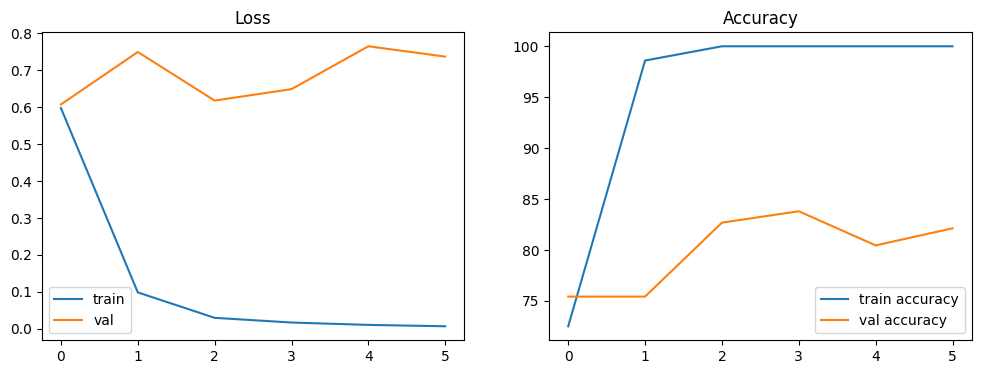

In [48]:
plot_history(history)